In [1]:
%pip install openai e2b_code_interpreter==1.0.0

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable

  Attempting uninstall: httpx

    Found existing installation: httpx 0.28.1

    Uninstalling httpx-0.28.1:

      Successfully uninstalled httpx-0.28.1

   ---------------------------------------- 0/2 [httpx]
  Attempting uninstall: e2b_code_interpreter
   ---------------------------------------- 0/2 [httpx]
    Found existing installation: e2b-code-interpreter 1.5.2
   ---------------------------------------- 0/2 [httpx]
    Uninstalling e2b-code-interpreter-1.5.2:
   ---------------------------------------- 0/2 [httpx]
      Successfully uninstalled e2b-code-interpreter-1.5.2
   ---------------------------------------- 0/2 [httpx]
   ---------------------------------------- 2/2 [e2b_code_interpreter]




ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llama-cloud-services 0.6.12 requires llama-index-core>=0.11.0, but you have llama-index-core 0.10.68 which is incompatible.
llama-cloud-services 0.6.12 requires python-dotenv<2.0.0,>=1.0.1, but you have python-dotenv 1.0.0 which is incompatible.
mcp 1.9.3 requires anyio>=4.5, but you have anyio 3.7.1 which is incompatible.
mcp 1.9.3 requires python-multipart>=0.0.9, but you have python-multipart 0.0.6 which is incompatible.
fastmcp 2.7.1 requires httpx>=0.28.1, but you have httpx 0.27.2 which is incompatible.
fastmcp 2.7.1 requires python-dotenv>=1.1.0, but you have python-dotenv 1.0.0 which is incompatible.
llama-index-agent-openai 0.4.9 requires llama-index-core<0.13,>=0.12.18, but you have llama-index-core 0.10.68 which is incompatible.
llama-index-embeddings-openai 0.3.1 requires llama-index-core<0.13.0,>=0.12

In [2]:
# Get your API keys or save them to .env file.
import os
from dotenv import load_dotenv
load_dotenv()

# TODO: Get your OpenAI API key
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# TODO: Get your E2B API key from https://e2b.dev/docs
E2B_API_KEY = os.getenv("E2B_API_KEY")


SYSTEM_PROMPT = """
## your job & context
you are a python data scientist. you are given tasks to complete and you run python code to solve them.
You DO NOT MAKE SYNTAX MISTAKES OR FORGET ANY IMPORTS
- the python code runs in jupyter notebook.
- every time you call `execute_python` tool, the python code is executed in a separate cell. it's okay to multiple calls to `execute_python`.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you have access to the internet and can make api requests.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
- you can run any python code you want, everything is running in a secure sandbox environment.
"""

tools = [
    {
        "type": "function",
        "function": {
          "name": "execute_python",
          "description": "Execute python code in a Jupyter notebook cell and returns any result, stdout, stderr, display_data, and error.",
          "parameters": {
              "type": "object",
              "properties": {
                  "code": {
                      "type": "string",
                      "description": "The python code to execute in a single cell."
                  }
              },
              "required": ["code"]
          }
        },
    }
]

In [3]:
def code_interpret(e2b_code_interpreter, code):
  print("Running code interpreter...")
  exec = e2b_code_interpreter.run_code(code,
  on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
  on_stdout=lambda stdout: print("[Code Interpreter]", stdout))

  if exec.error:
    print("[Code Interpreter ERROR]", exec.error)
  else:
    return exec.results

In [4]:
from openai import OpenAI
import json

client = OpenAI(api_key=OPENAI_API_KEY)

def chat(e2b_code_interpreter, user_message, base64_image = None, ):
  print(f"\n{'='*50}\nUser Message: {user_message}\n{'='*50}")

  messages = [
      {
          "role": "system",
          "content": SYSTEM_PROMPT,
      },
  ]

  if base64_image is not None:
    messages.append(
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": user_message,
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
              }
            }
          ]
        }
    )
  else:
    messages.append(
        {"role": "user", "content": user_message},
    )

  response = client.chat.completions.create(
    model="gpt-4o",
    messages=messages,
    tools=tools,
    tool_choice="auto"
  )
  for choice in response.choices:
    if choice.message.tool_calls and len(choice.message.tool_calls) > 0:
      for tool_call in choice.message.tool_calls:
        if tool_call.function.name == "execute_python":
          if isinstance(tool_call.function.arguments, dict) and "code" in tool_call.function.arguments:
            code = tool_call.function.arguments["code"]
          else:
            code = json.loads(tool_call.function.arguments)["code"]

            print("CODE TO RUN")
            print(code)
            code_interpreter_results = code_interpret(e2b_code_interpreter, code)
            return code_interpreter_results
    else:
      print("Answer:", choice.message.content)


User Message: Plot a chart visualizing the height distribution of men based on the data you know
CODE TO RUN
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Generating some synthetic data for men's height distribution
np.random.seed(0)
# Assuming a normal distribution of men's heights
heights = np.random.normal(loc=175, scale=10, size=1000)  # loc is mean, scale is std deviation, size is sample size

# Plotting
def plot_height_distribution(data):
    plt.figure(figsize=(10, 6))
    sns.histplot(data, bins=30, kde=True, color='skyblue', edgecolor='black')
    plt.title('Height Distribution of Men')
    plt.xlabel('Height (cm)')
    plt.ylabel('Frequency')
    plt.xlim(140, 210)  # reasonable limit for men's heights
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_height_distribution(heights)
Running code interpreter...
[Result(<Figure size 1000x600 with 1 Axes>)]


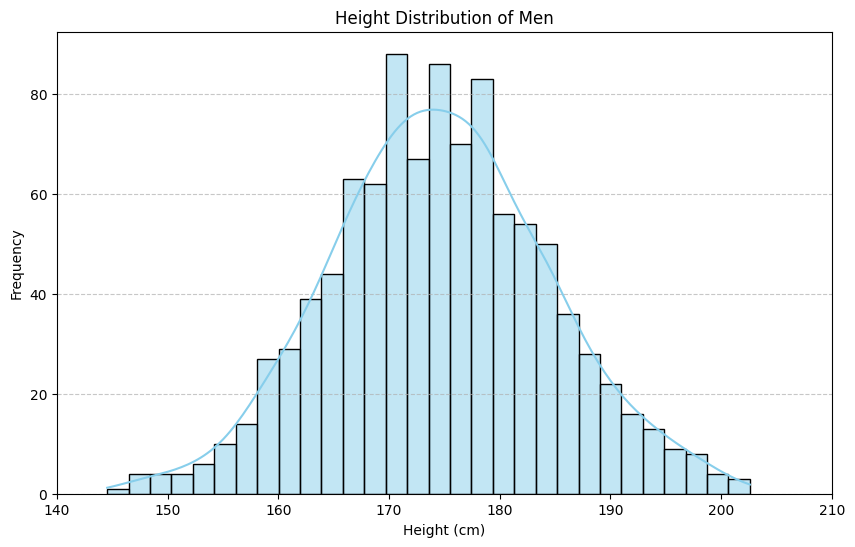

In [5]:
from e2b_code_interpreter import Sandbox
code_interpreter = Sandbox(api_key=E2B_API_KEY)

# 1. Ask GPT-4o to generate chart
code_interpreter_results = chat(
  code_interpreter,
  "Plot a chart visualizing the height distribution of men based on the data you know",
)
print(code_interpreter_results)
plot1 = code_interpreter_results[0]

plot1


User Message: Based on what you see, what's name of this distribution? Make a plot of the distribution function
CODE TO RUN
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for the normal distribution
mean = 175  # mean height in cm
std_dev = 10  # standard deviation

# Generate data points
x = np.linspace(140, 210, 1000)
y = norm.pdf(x, mean, std_dev)

# Plot the distribution function
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Normal Distribution', color='skyblue')
plt.title('Normal Distribution PDF')
plt.xlabel('Height (cm)')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()
Running code interpreter...
[Result(<Figure size 1000x600 with 1 Axes>)]


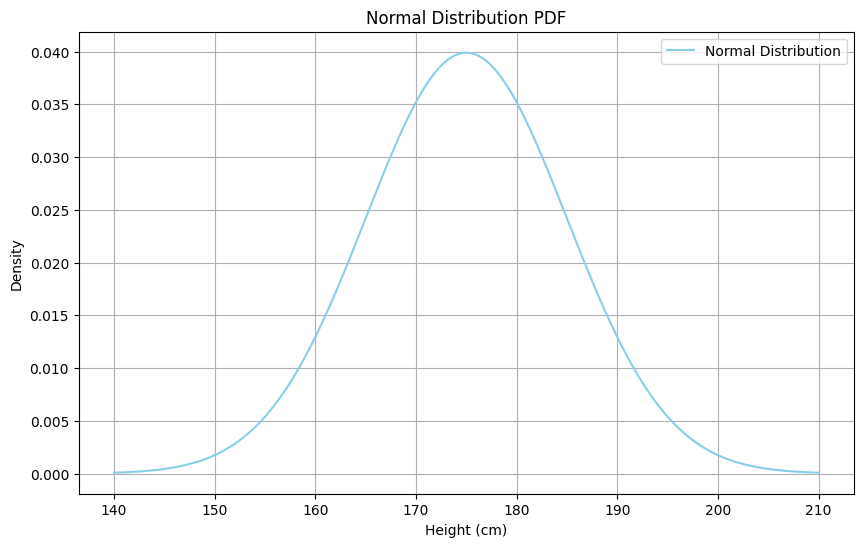

In [6]:
# 2. Feed the image back the chart to GPT-4o and ask question about the image
image = plot1.png
code_interpreter_results = chat(
  code_interpreter,
  "Based on what you see, what's name of this distribution? Make a plot of the distribution function",
  image,
)

code_interpreter.kill()

print(code_interpreter_results)
plot2 = code_interpreter_results[0]
plot2